In [1]:
import requests
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&time_start=2017-05-01T00:00:00&limit=1400'
headers = {'X-CoinAPI-Key' : '77E6573F-0353-4C2F-ADFF-7051D9126CED'}
response = requests.get(url, headers=headers).json()

In [20]:
dataset = pd.DataFrame(response)

# delete unnecessary rows and change date format
dataset.drop(['time_period_end','time_open','time_close', 'price_open', 'price_high', 'price_low'], axis=1, inplace=True)
dataset['time_period_start'] = pd.to_datetime(dataset['time_period_start'])
dataset['time_period_start'] = dataset['time_period_start'].dt.date

# change index to date column
dataset.set_index('time_period_start',inplace=True)
dataset.head(5)

,price_close,volume_traded,trades_count
time_period_start,,,
2017-05-01,1390.86,8604.414932,9070
2017-05-02,1447.75,8864.557111,7601
2017-05-03,1503.22,11077.239687,10633
2017-05-04,1537.23,19548.529737,18380
2017-05-05,1514.90,15603.684366,18175


In [21]:
dataset.shape

(1400, 3)

<function matplotlib.pyplot.show(*args, **kw)>

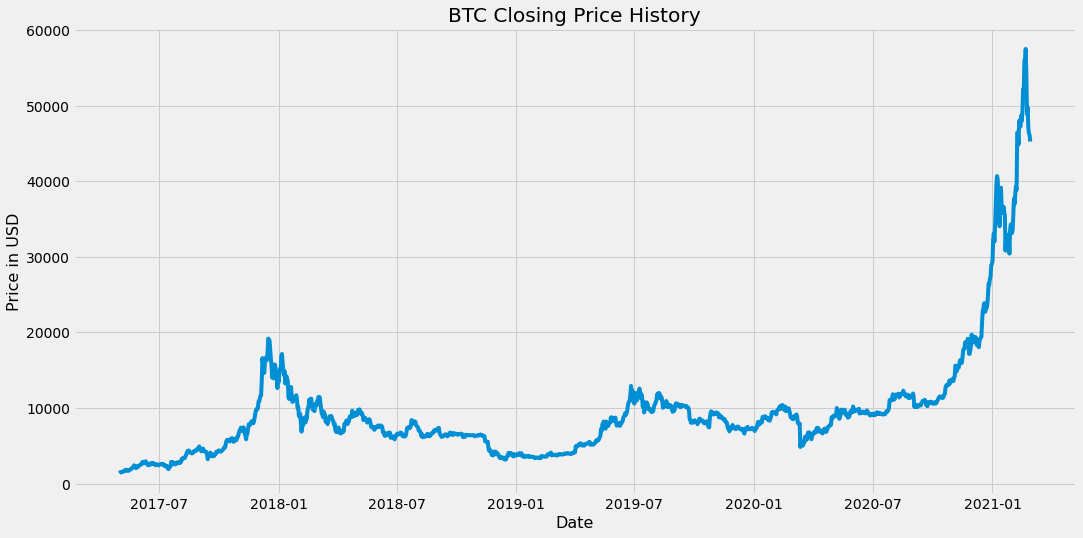

In [22]:
# Visualize Closing Price
plt.figure(figsize=(16,8))
plt.title('BTC Closing Price History')
plt.plot(dataset['price_close'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price in USD', fontsize=16)
plt.show

In [23]:
# Filter Closing Price and create Array
closingPrice = dataset.filter(['price_close'])
cp_dataset = closingPrice.values

# Get Number of rows to train model
training_data_len = math.ceil(len(cp_dataset) * 0.75)

training_data_len

1050

In [24]:
# Scale data (normalize)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(cp_dataset)

scaled_data

array([[0.        ],
       [0.00101404],
       [0.00200278],
       ...,
       [0.80075452],
       [0.79710314],
       [0.78161315]])

In [7]:
# Create training Dataset
# scaled training dataset
train_data = scaled_data[0:training_data_len , :]
#Split data into x_train and y_train
x_train = []
y_train = []

for i in range(90, len(train_data)):
    x_train.append(train_data[i-90:i, 0])
    y_train.append(train_data[i, 0])

In [8]:
# Convert training data to numpy array
x_train,y_train = np.array(x_train), np.array(y_train)

In [9]:
# Reshape data to 3-dimensional for LSTM Input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(960, 90, 1)

In [10]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (90,1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [11]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# train model
model.fit(x_train, y_train, batch_size=1, epochs=1)

960/960 [==============================] - 38s 37ms/step - loss: 4.0174e-04


In [13]:
# Create testing Dataset
# Create new array containing scaled values from index 210 to 300
test_data = scaled_data[training_data_len-90: , :]
# Create Datasets x_test and y_test
x_test = []
y_test = cp_dataset[training_data_len: , :]
for i in range(90, len(test_data)):
    x_test.append(test_data[i-90:i, 0])


In [14]:
# Convert data to numpy array
x_test = np.array(x_test)

In [15]:
# Reshape test data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [16]:
# get predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [17]:
# get root mean squared error -> evaluate model
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1271.1874871651783

<ipython-input-18-949511acfc94>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


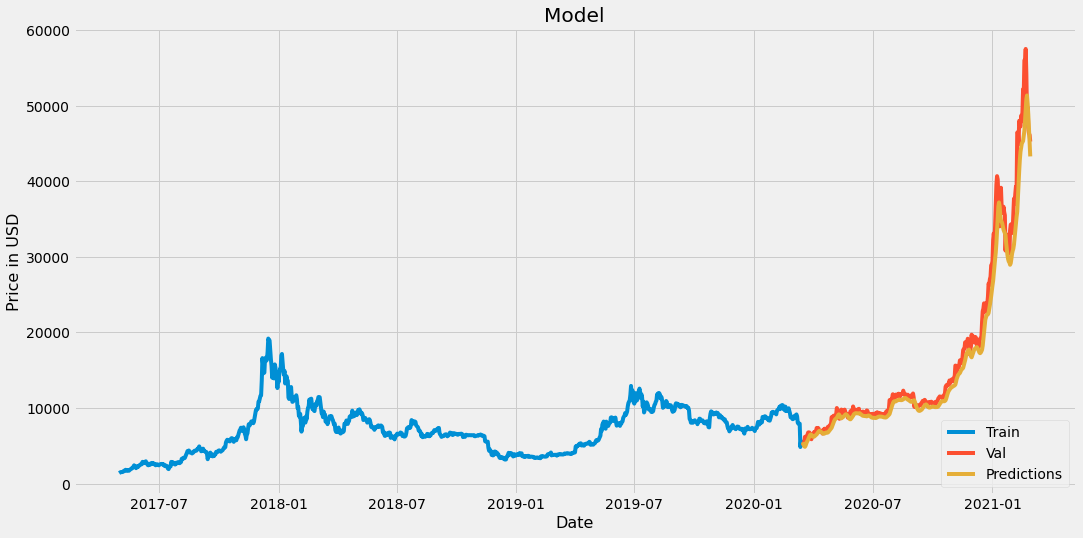

In [18]:
# Plot data
train = closingPrice[:training_data_len]
valid = closingPrice[training_data_len:]
valid['Predictions'] = predictions

# Visualize data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price in USD', fontsize=16)
plt.plot(train['price_close'])
plt.plot(valid[['price_close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [19]:
# Show valid and predicted prices
valid

,price_close,Predictions
time_period_start,,
2020-03-16,5033.42,5481.036621
2020-03-17,5324.99,5124.686523
2020-03-18,5406.92,4930.178223
2020-03-19,6181.18,4868.453613
2020-03-20,6210.14,5015.602051
...,...,...
2021-02-24,49754.00,50241.847656
2021-02-25,47088.58,48801.562500
2021-02-26,46314.83,46880.320312
